In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

spark = SparkSession.builder \
    .appName("APP_1") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", FloatType(), True)
])
# Read ratings.csv
df = spark.read.csv("ratings.csv", header=True, schema = schema).cache()

In [27]:
# try:
#     spark.stop()
# except:
#     pass

In [2]:
print("Rows:", df.count())
print("Unique users:", df.select("userId").distinct().count())
print("Unique Movies:", df.select("movieId").distinct().count())

Rows: 32000204
Unique users: 200948
Unique Movies: 84432


In [3]:
# Select first n unique users
unique_users = df.select("userId").distinct().limit(1000)

# Keep only rows from these users
df = df.join(unique_users, on="userId", how="inner")

df.show(5)
print("Rows:", df.count())
print("Unique users:", df.select("userId").distinct().count())
print("Unique Movies:", df.select("movieId").distinct().count())

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|    28|      1|   4.0|
|    28|      2|   3.0|
|    28|      3|   4.0|
|    28|      5|   2.0|
|    28|      6|   3.0|
+------+-------+------+
only showing top 5 rows
Rows: 154972
Unique users: 1000
Unique Movies: 11459


In [4]:
from pyspark.sql.functions import col, round as spark_round
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array

user_indexer = StringIndexer(inputCol="userId", outputCol="user")
movie_indexer = StringIndexer(inputCol="movieId", outputCol="movie")
assembler = VectorAssembler(inputCols=["rating"], outputCol="rating_vec")
scaler = MinMaxScaler(inputCol="rating_vec", outputCol="rating_scaled")

pipeline = Pipeline(stages=[user_indexer, movie_indexer, assembler, scaler])

pipeline_model = pipeline.fit(df)
scaled_df = pipeline_model.transform(df)

# Flatten vector -> float, then round to 1 decimal
scaled_df = scaled_df.withColumn(
    "rating_scaled",
    spark_round(vector_to_array(col("rating_scaled"))[0], 1)
)

# Keep only necessary columns
df_final = scaled_df.select("user", "movie", "rating_scaled")
df_final = df_final.cache()
df_final.show(5)

+----+-----+-------------+
|user|movie|rating_scaled|
+----+-----+-------------+
| 0.0| 11.0|          0.8|
| 0.0|157.0|          0.6|
| 0.0|456.0|          0.8|
| 0.0|389.0|          0.3|
| 0.0|139.0|          0.6|
+----+-----+-------------+
only showing top 5 rows


In [5]:
# Split df_final into 10 random parts (equal fractions)
fractions = [0.1] * 5   # 10 equal splits
splits = df_final.randomSplit(fractions, seed=42)

# Check the sizes
for i, part in enumerate(splits):
    n_users = part.select("user").distinct().count()
    n_movies = part.select("movie").distinct().count()
    print(f"Split {i+1}: {n_users} unique users, {n_movies} unique movies, {part.count()} rows")

Split 1: 999 unique users, 6188 unique movies, 31175 rows
Split 2: 1000 unique users, 6148 unique movies, 31020 rows
Split 3: 1000 unique users, 6140 unique movies, 30955 rows
Split 4: 999 unique users, 6119 unique movies, 30677 rows
Split 5: 998 unique users, 6232 unique movies, 31145 rows


In [6]:
for i, part in enumerate(splits):
    row = part.limit(1).collect() # Limit to one row and collect brings row from spark to python
    print(f"Model {i+1} sample row: {row}")

Model 1 sample row: [Row(user=0.0, movie=7.0, rating_scaled=1.0)]
Model 2 sample row: [Row(user=0.0, movie=3.0, rating_scaled=0.8)]
Model 3 sample row: [Row(user=0.0, movie=1.0, rating_scaled=1.0)]
Model 4 sample row: [Row(user=0.0, movie=0.0, rating_scaled=1.0)]
Model 5 sample row: [Row(user=0.0, movie=2.0, rating_scaled=1.0)]


In [7]:
# import torch 

# all_data = []

# for i,part in enumerate(splits):
#     print(f"\n=== Processing Split {i+1} ===")

#     train_df,test_df = part.randomSplit([0.8, 0.2], seed=42)

#     # Convert to Pandas
#     train_pd = train_df.toPandas()
#     test_pd = test_df.toPandas()

#     # Step 3: convert to torch tensors
#     X_train = torch.tensor(train_pd[["user", "movie"]].values)
#     y_train = torch.tensor(train_pd["rating_scaled"].values)
    
#     X_test = torch.tensor(test_pd[["user", "movie"]].values)
#     y_test = torch.tensor(test_pd["rating_scaled"].values)
    
#     # Print stats
#     print("Train count:", X_train.shape[0], "| Train labels:", y_train.shape[0])
#     print("Test count:", X_test.shape[0], "| Test labels:", y_test.shape[0])

#     all_data.append({
#         "X_train": X_train,
#         "y_train": y_train,
#         "X_test": X_test,
#         "y_test": y_test
#     })

In [7]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [8]:
import torch 

all_data = []

for i, part in enumerate(splits):
    print(f"\n=== Processing Split {i+1} ===")
   
    train_df, test_df = part.randomSplit([0.8, 0.2], seed=42)
    print("split done")
    # Convert to Pandas
    train_pd = train_df.toPandas()
    test_pd = test_df.toPandas()
    print("split2 done")
    # Make sure indices are integers
    train_pd["user"] = train_pd["user"].astype(int)
    train_pd["movie"] = train_pd["movie"].astype(int)
    test_pd["user"] = test_pd["user"].astype(int)
    test_pd["movie"] = test_pd["movie"].astype(int)
    print("split3 done")
    # Convert to torch tensors
    X_train = torch.tensor(train_pd[["user", "movie"]].values, dtype=torch.long)  # for embedding
    y_train = torch.tensor(train_pd["rating_scaled"].values, dtype=torch.float)  # for MSE loss

    X_test = torch.tensor(test_pd[["user", "movie"]].values, dtype=torch.long)
    y_test = torch.tensor(test_pd["rating_scaled"].values, dtype=torch.float)

    # Print stats
    print("Train count:", X_train.shape[0], "| Train labels:", y_train.shape[0])
    print("Test count:", X_test.shape[0], "| Test labels:", y_test.shape[0])

    all_data.append({
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test
    })



=== Processing Split 1 ===
split done
split2 done
split3 done
Train count: 24961 | Train labels: 24961
Test count: 6214 | Test labels: 6214

=== Processing Split 2 ===
split done
split2 done
split3 done
Train count: 24840 | Train labels: 24840
Test count: 6180 | Test labels: 6180

=== Processing Split 3 ===
split done
split2 done
split3 done
Train count: 24790 | Train labels: 24790
Test count: 6165 | Test labels: 6165

=== Processing Split 4 ===
split done
split2 done
split3 done
Train count: 24573 | Train labels: 24573
Test count: 6104 | Test labels: 6104

=== Processing Split 5 ===
split done
split2 done
split3 done
Train count: 24937 | Train labels: 24937
Test count: 6208 | Test labels: 6208


In [9]:
from torch.utils.data import TensorDataset, DataLoader

all_loaders = []  

for i, d in enumerate(all_data):
    # Create TensorDataset
    train_dataset = TensorDataset(d["X_train"], d["y_train"])
    test_dataset = TensorDataset(d["X_test"], d["y_test"])

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,drop_last=True)

    # Save loaders for later training
    all_loaders.append({
        "train_loader": train_loader,
        "test_loader": test_loader
    })

print(f"\nCreated DataLoaders for {len(all_loaders)} splits")


Created DataLoaders for 5 splits


In [55]:
# import torch.nn as nn
# import torch.nn.functional as F

# class CollabFiltering(nn.Module):
#     def __init__(self, n_users, n_movies, emb_dim, hidden, dropout):
#         super().__init__()
#         self.user_emb = nn.Embedding(n_users, emb_dim)   #n_users * emb_dim = 50 * 16 = 800
#         self.movie_emb = nn.Embedding(n_movies, emb_dim)  #n_movies * emb_dim = 3524 * 16 = 56,384

#         self.mlp = nn.Sequential(
#             nn.Linear(emb_dim * 2, hidden),  # user+movie embeddings concatenated 16*2*32 + 32 = 1056
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden, 1),  #32*1 + 1 = 33
#             nn.Sigmoid()  # predict rating
#         )

#     def forward(self,user,movie):
#         u = F.dropout(self.user_emb(user), p=0.4, training=self.training)
#         m = F.dropout(self.movie_emb(movie), p=0.4, training=self.training)
        
#         # Concatenate embeddings (instead of dot product)
#         x = torch.cat([u, m], dim=1)
        
#         # Pass through MLP
#         return self.mlp(x).squeeze()


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class CollabFiltering(nn.Module):
    def __init__(self, n_users, n_movies, emb_dim, hidden, dropout):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)   #n_users * emb_dim = 50 * 16 = 800
        self.movie_emb = nn.Embedding(n_movies, emb_dim)  #n_movies * emb_dim = 3524 * 16 = 56,384
        self.dropout_emb = 0.4

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, hidden), # user+movie embeddings concatenated 16*2*32 + 32 = 1056
            nn.BatchNorm1d(hidden),  
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1),  #32*1 + 1 = 33
            nn.Sigmoid()  # predict rating
        )

    def forward(self,user,movie):
        u = F.dropout(self.user_emb(user), p=self.dropout_emb, training=self.training)
        m = F.dropout(self.movie_emb(movie), p=self.dropout_emb, training=self.training)
        
        # Concatenate embeddings (instead of dot product)
        x = torch.cat([u, m], dim=1)
        
        # Pass through MLP
        return self.mlp(x).squeeze()


In [11]:
loss_fn = nn.MSELoss() # regression on ratings

In [ ]:
def adam(parameter, m_state, v_state, t, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    # Loop over Tensors in model.parameters()
    for p in parameter:
        if p.grad is None:
            continue

        # First Time seeing this parameter
        if p not in m_state:
            m_state[p] = torch.zeros_like(p)
            v_state[p] = torch.zeros_like(p)

        g = p.grad
        # First moment
        m_state[p] = beta1 * m_state[p] + (1 - beta1) * g
        # Second moment
        v_state[p] = beta2 * v_state[p] + (1 - beta2) * (g * g)

        # Bias correction
        m_corrected = m_state[p] / (1 - beta1 ** t)
        v_corrected = v_state[p] / (1 - beta2 ** t)

        # Parameter update (in-place)
        p.data -= lr * m_corrected / (torch.sqrt(v_corrected) + epsilon)

    return m_state, v_state



================ Stage 1: Training Node 1 on Split 1 ================
Node 1 | Epoch 2/10 | Train Loss: 0.0456, Train RMSE: 0.2135 | Test Loss: 0.0442, Test RMSE: 0.2102
Node 1 | Epoch 4/10 | Train Loss: 0.0406, Train RMSE: 0.2015 | Test Loss: 0.0442, Test RMSE: 0.2103
Node 1 | Epoch 6/10 | Train Loss: 0.0384, Train RMSE: 0.1959 | Test Loss: 0.0444, Test RMSE: 0.2107
Node 1 | Epoch 8/10 | Train Loss: 0.0379, Train RMSE: 0.1948 | Test Loss: 0.0478, Test RMSE: 0.2185
Node 1 | Epoch 10/10 | Train Loss: 0.0369, Train RMSE: 0.1921 | Test Loss: 0.0473, Test RMSE: 0.2174

================ Stage 1: Training Node 2 on Split 2 ================
Node 2 | Epoch 2/10 | Train Loss: 0.0466, Train RMSE: 0.2158 | Test Loss: 0.0449, Test RMSE: 0.2119
Node 2 | Epoch 4/10 | Train Loss: 0.0414, Train RMSE: 0.2034 | Test Loss: 0.0443, Test RMSE: 0.2105
Node 2 | Epoch 6/10 | Train Loss: 0.0398, Train RMSE: 0.1995 | Test Loss: 0.0458, Test RMSE: 0.2139
Node 2 | Epoch 8/10 | Train Loss: 0.0385, Train RMSE: 0.1

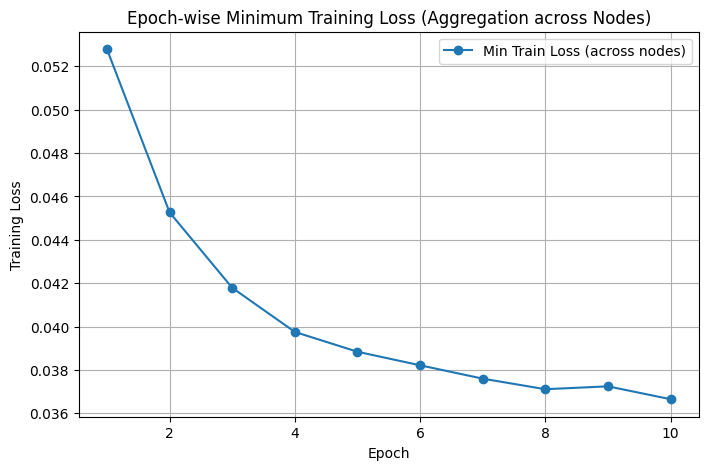

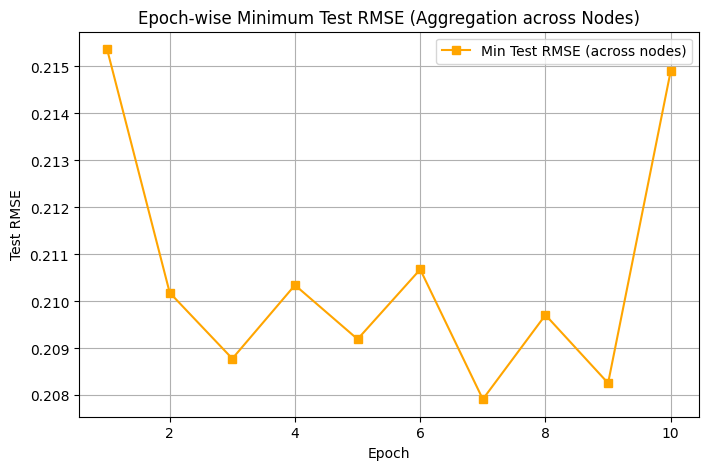

In [31]:
import copy
import matplotlib.pyplot as plt

# ---------- Settings ----------
epochs_stage1 = 10
all_candidates_stage1 = []  # store every node's per-epoch stats
min_train_curve = []        # aggregated minimum train loss after each epoch
min_test_rmse_curve = []

n_users_global = df_final.select("user").distinct().count()
n_movies_global = df_final.select("movie").distinct().count()

# ---------- Stage 1: Train 5 nodes on dataset splits ----------
for i, (part, loaders) in enumerate(zip(splits, all_loaders), start=1):
    print(f"\n================ Stage 1: Training Node {i} on Split {i} ================")

    node = CollabFiltering(n_users_global, n_movies_global, emb_dim=16, hidden=16, dropout=0.1)
    m_state, v_state, t = {}, {}, 0

    train_loader = loaders["train_loader"]
    test_loader = loaders["test_loader"]

    # Per-epoch storage
    train_losses_epoch = []
    test_losses_epoch = []
    train_rmses_epoch = []
    test_rmses_epoch = []
    epoch_states = []

    for epoch in range(epochs_stage1):
        # ---------- Training ----------
        node.train()
        total_sq_error, total_samples = 0, 0
        total_loss = 0

        for X_batch, y_batch in train_loader:
            preds = node(X_batch[:,0].long(), X_batch[:,1].long()).squeeze()
            loss = loss_fn(preds, y_batch.float())

            node.zero_grad()
            loss.backward()
            t += 1
            m_state, v_state = adam(node.parameters(), m_state, v_state, t)

            total_loss += loss.item()
            total_sq_error += torch.sum((preds - y_batch) ** 2).item()
            total_samples += len(y_batch)

        train_loss = total_loss / len(train_loader)
        train_rmse = (total_sq_error / total_samples) ** 0.5

        # ---------- Testing ----------
        node.eval()
        total_sq_error, total_samples, total_loss = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                preds = node(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())

                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch) ** 2).item()
                total_samples += len(y_batch)

        test_loss = total_loss / len(test_loader)
        test_rmse = (total_sq_error / total_samples) ** 0.5

        # ---------- Save per-epoch stats ----------
        train_losses_epoch.append(train_loss)
        test_losses_epoch.append(test_loss)
        train_rmses_epoch.append(train_rmse)
        test_rmses_epoch.append(test_rmse)
        epoch_states.append(node.state_dict())
        
        if (epoch + 1) % 2 == 0:
            print(f"Node {i} | Epoch {epoch+1}/{epochs_stage1} | "
                f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | "
                f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")


    # ---------- Store all info for this node ----------
    all_candidates_stage1.append({
        "node": i,
        "train_losses": train_losses_epoch,
        "test_losses": test_losses_epoch,
        "train_rmses": train_rmses_epoch,
        "test_rmses": test_rmses_epoch,
        "epoch_states": epoch_states
    })

# ---------- Aggregation (MIN across nodes for each epoch) ----------
for epoch in range(epochs_stage1):
    min_loss = min(node["train_losses"][epoch] for node in all_candidates_stage1)
    min_train_curve.append(min_loss)
    min_test_rmse = min(node["test_rmses"][epoch] for node in all_candidates_stage1)
    min_test_rmse_curve.append(min_test_rmse)


# ---------- Plot ----------
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs_stage1+1), min_train_curve, marker="o", label="Min Train Loss (across nodes)")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Epoch-wise Minimum Training Loss (Aggregation across Nodes)")
plt.legend()
plt.grid(True)
plt.show()

# ---------- Plot Test RMSE ----------
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs_stage1+1), min_test_rmse_curve, marker="s", color="orange", label="Min Test RMSE (across nodes)")
plt.xlabel("Epoch")
plt.ylabel("Test RMSE")
plt.title("Epoch-wise Minimum Test RMSE (Aggregation across Nodes)")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
import utils

# Save the aggregated curves instead of all node details
aggregated_curves = {
    "min_train_curve": min_train_curve,
    "min_test_rmse_curve": min_test_rmse_curve
}

utils.save_results("results/data_split.pkl", aggregated_curves)


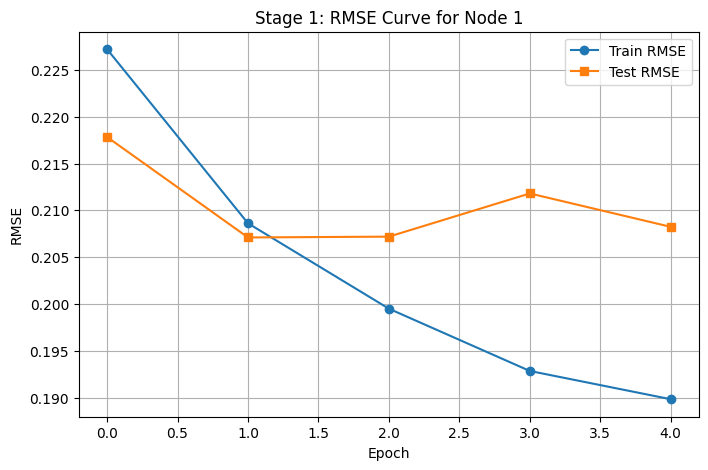

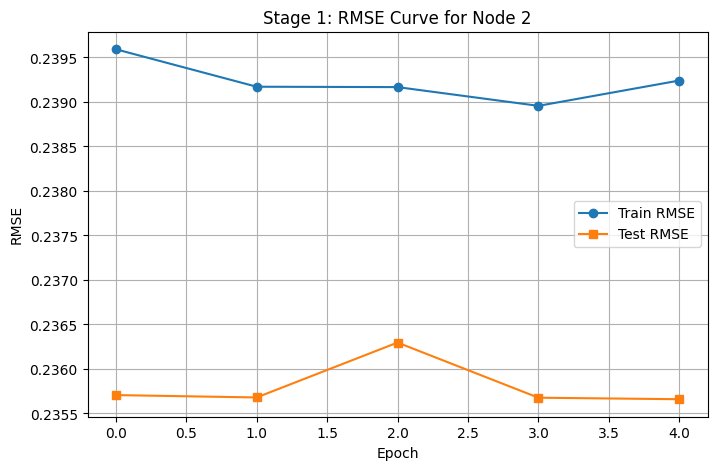

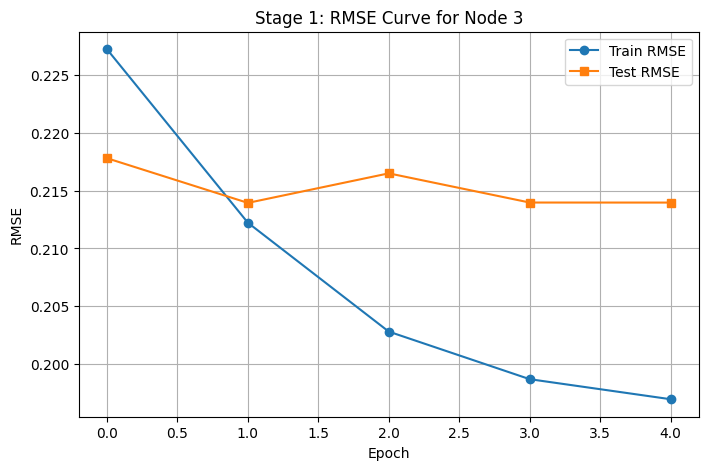

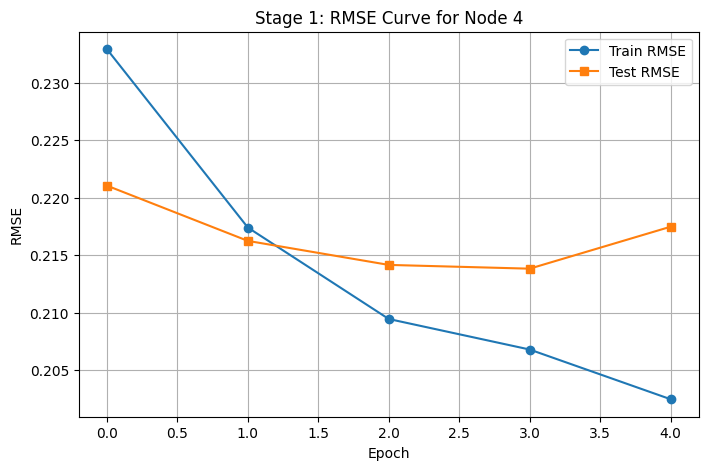

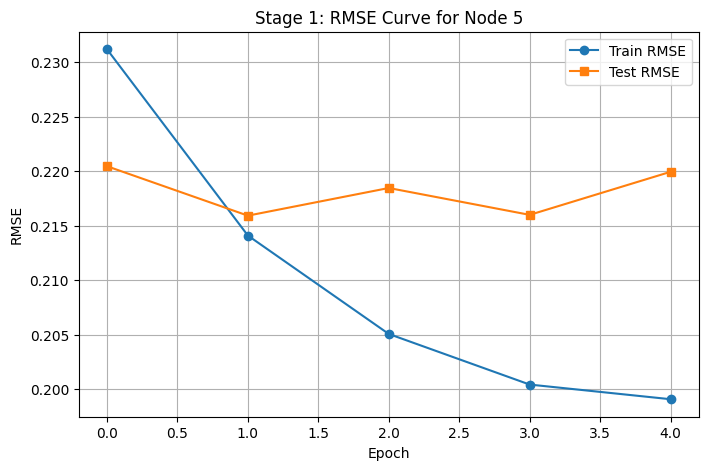

In [21]:
import matplotlib.pyplot as plt

for result in all_candidates_stage1:
    node_id = result["node"]   # updated from "split"
    train_rmses = result["train_rmses"]
    test_rmses = result["test_rmses"]

    plt.figure(figsize=(8,5))
    plt.plot(train_rmses, label="Train RMSE", marker='o')
    plt.plot(test_rmses, label="Test RMSE", marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.title(f"Stage 1: RMSE Curve for Node {node_id}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# all_candidates already contains each model's final state_dict and metrics

# Step 1: Collect all state_dicts
# Each state_dict is a dictionary mapping parameter names to tensors (weights/biases)
all_states = [cand["state_dict"] for cand in all_candidates_stage1]

# Step 2: Initialize dictionary for global averaged weights
global_state = {}

# Step 3: Average weights across all splits
for key in all_states[0].keys():
    # Sum the same parameter across all models and divide by number of models
    global_state[key] = sum([state[key] for state in all_states]) / len(all_states)

    
print("\n🌍 Global weights computed via simple averaging across all splits.\n")

# Step 4: Print a few sample values to see what’s inside
for key in list(global_state.keys())[:5]:  # print first 5 parameters only
    print(f"Parameter: {key} | Mean of first 5 elements: {global_state[key].flatten()[:5].tolist()}")



🌍 Global weights computed via simple averaging across all splits.

Parameter: user_emb.weight | Mean of first 5 elements: [0.02109518088400364, 0.21947118639945984, 0.387261301279068, -0.5472716689109802, -1.0561814308166504]
Parameter: movie_emb.weight | Mean of first 5 elements: [5.072567462921143, 4.529562950134277, 2.4849700927734375, 0.7006827592849731, -0.4521235525608063]
Parameter: mlp.0.weight | Mean of first 5 elements: [0.5146845579147339, -0.6195929646492004, 0.00983658991754055, 0.46202364563941956, 0.22956371307373047]
Parameter: mlp.0.bias | Mean of first 5 elements: [0.02184905670583248, 0.010286073200404644, -0.009244012646377087, -0.015723910182714462, 0.05287434905767441]
Parameter: mlp.1.weight | Mean of first 5 elements: [-0.04995758458971977, -0.10865084826946259, -0.02613658271729946, 0.041274022310972214, 0.252640038728714]


In [ ]:

# Step 1: Collect best epoch state_dicts from each model
best_epoch_states = []

for cand in all_candidates_stage1:
    # Find epoch with lowest test RMSE
    best_idx = cand['test_rmses'].index(min(cand['test_rmses']))
    best_state = cand['epoch_states'][best_idx]
    best_epoch_states.append(best_state)

# Step 2: Average weights across all models
global_state = {}

for key in best_epoch_states[0].keys():
    # Sum weights for this parameter across all models
    param_sum = sum([state[key] for state in best_epoch_states])
    global_state[key] = param_sum / len(best_epoch_states)

print("\n🌍 Global weights computed via averaging the best epoch (lowest test RMSE) per model.\n")

# Step 3: Print a few sample values
for key in list(global_state.keys())[:5]:  # first 5 parameters only
    print(f"Parameter: {key} | Mean of first 5 elements: {global_state[key].flatten()[:5].tolist()}")



🌍 Global weights computed via averaging the best epoch (lowest test RMSE) per model.

Parameter: user_emb.weight | Mean of first 5 elements: [-0.16909177601337433, 0.9161926507949829, -0.1875031590461731, 0.8945075869560242, 0.936205267906189]
Parameter: movie_emb.weight | Mean of first 5 elements: [2.006695508956909, -2.7690329551696777, 0.6509990692138672, -0.5273876190185547, -3.014566421508789]
Parameter: mlp.0.weight | Mean of first 5 elements: [-1.003118872642517, 0.30591651797294617, 0.4643678069114685, -0.6284362077713013, 1.0094711780548096]
Parameter: mlp.0.bias | Mean of first 5 elements: [-0.07980235666036606, 0.004563285503536463, -0.09052175283432007, -0.03762251138687134, 0.02947130799293518]
Parameter: mlp.1.weight | Mean of first 5 elements: [0.15544083714485168, 0.10741093009710312, 0.1481574922800064, 0.07482245564460754, 0.02955758199095726]


In [26]:
import copy
import matplotlib.pyplot as plt

epochs_stage2 = 5
all_result_stage2 = []

for i, (part, loaders) in enumerate(zip(splits, all_loaders), start=1):
    print(f"\n================ Stage 2: Training Model {i} on Split {i} ================")

    # Initialize model and load global weights
    model = CollabFiltering(n_users_global, n_movies_global, emb_dim=16, hidden=16, dropout=0.1)
    model.load_state_dict(global_state)  # assume global_state exists

    m_state, v_state, t = {}, {}, 0

    train_loader = loaders["train_loader"]
    test_loader = loaders["test_loader"]

    # Per-epoch storage
    train_losses_epoch = []
    test_losses_epoch = []
    train_rmses_epoch = []
    test_rmses_epoch = []
    epoch_states = []

    for epoch in range(epochs_stage2):
        # ---------- Training ----------
        model.train()
        total_sq_error, total_samples, total_loss = 0, 0, 0

        for X_batch, y_batch in train_loader:
            preds = model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
            loss = loss_fn(preds, y_batch.float())

            model.zero_grad()
            loss.backward()
            t += 1
            m_state, v_state = adam(model.parameters(), m_state, v_state, t)

            total_loss += loss.item()
            total_sq_error += torch.sum((preds - y_batch) ** 2).item()
            total_samples += len(y_batch)

        train_loss = total_loss / len(train_loader)
        train_rmse = (total_sq_error / total_samples) ** 0.5

        # ---------- Testing ----------
        model.eval()
        total_sq_error, total_samples, total_loss = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                preds = model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())

                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch) ** 2).item()
                total_samples += len(y_batch)

        test_loss = total_loss / len(test_loader)
        test_rmse = (total_sq_error / total_samples) ** 0.5

        # ---------- Print per-epoch summary ----------
        print(f"Model {i} | Epoch {epoch+1}/{epochs_stage2} | "
              f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

        # ---------- Store per-epoch stats ----------
        train_losses_epoch.append(train_loss)
        test_losses_epoch.append(test_loss)
        train_rmses_epoch.append(train_rmse)
        test_rmses_epoch.append(test_rmse)
        epoch_states.append(copy.deepcopy(model.state_dict()))

    # ---------- Store all info for this split ----------
    all_result_stage2.append({
        "split": i,
        "train_losses": train_losses_epoch,
        "test_losses": test_losses_epoch,
        "train_rmses": train_rmses_epoch,
        "test_rmses": test_rmses_epoch,
        "epoch_states": epoch_states
    })

print("\n================ Stage 2 Complete ================")



================ Stage 2: Training Model 1 on Split 1 ================
Model 1 | Epoch 1/5 | Train Loss: 0.0453, Train RMSE: 0.2127 | Test Loss: 0.0433, Test RMSE: 0.2081
Model 1 | Epoch 2/5 | Train Loss: 0.0424, Train RMSE: 0.2059 | Test Loss: 0.0483, Test RMSE: 0.2197
Model 1 | Epoch 3/5 | Train Loss: 0.0403, Train RMSE: 0.2008 | Test Loss: 0.0440, Test RMSE: 0.2098
Model 1 | Epoch 4/5 | Train Loss: 0.0391, Train RMSE: 0.1977 | Test Loss: 0.0436, Test RMSE: 0.2088
Model 1 | Epoch 5/5 | Train Loss: 0.0387, Train RMSE: 0.1967 | Test Loss: 0.0448, Test RMSE: 0.2116

================ Stage 2: Training Model 2 on Split 2 ================
Model 2 | Epoch 1/5 | Train Loss: 0.0468, Train RMSE: 0.2163 | Test Loss: 0.0424, Test RMSE: 0.2059
Model 2 | Epoch 2/5 | Train Loss: 0.0436, Train RMSE: 0.2088 | Test Loss: 0.0428, Test RMSE: 0.2070
Model 2 | Epoch 3/5 | Train Loss: 0.0413, Train RMSE: 0.2033 | Test Loss: 0.0439, Test RMSE: 0.2094
Model 2 | Epoch 4/5 | Train Loss: 0.0414, Train RMSE: 0.